# Predicting Breast Tumor Malignancy with Deep Convolutional Models

![BreakHisPics](https://www.researchgate.net/publication/327528970/figure/fig2/AS:776781296582657@1562210501567/BreakHis-dataset-composed-of-benign-and-malignant-images-benign-a-adenosis-b.jpg)

## Introduction

Histopathological image analysis plays a crucial role in breast cancer diagnosis, enabling pathologists to distinguish between benign and malignant tissue samples.  
The **BreakHis dataset** provides a large collection of microscopic images captured at different **magnification levels** (40×, 100×, 200×, 400×).  
Each image belongs to one of two categories — *benign* or *malignant* — and originates from real biopsy samples.  

This project aims to develop and compare several deep learning models for automated tumor classification:
1. A **baseline CNN** trained from scratch.  
2. A **fine-tuned ResNet18**, leveraging transfer learning from ImageNet.  
3. A **FiLM-based ResNet18**, which integrates magnification information to adapt feature extraction dynamically.

While **magnification** does not directly determine tumor class, it provides valuable contextual information.  
Different scales reveal distinct tissue structures — from cellular morphology at high magnification to global organization at low magnification.  
The FiLM-based approach uses this metadata to modulate intermediate features, allowing the model to learn *how* to extract relevant features depending on the imaging scale.

The notebook follows a clear experimental workflow:
- **Data preparation:** loading, sampling, and preprocessing the BreakHis dataset.  
- **Model development:** progressively more complex architectures, from baseline CNN to FiLM-ResNet18.  
- **Training and evaluation:** including weighted loss functions to handle class imbalance, early stopping, and learning rate scheduling.  
- **Comparison and analysis:** evaluating models on balanced accuracy, F1-score, precision, recall, and ROC-AUC.

Through these experiments, the study demonstrates how incorporating contextual cues like magnification — even if not directly predictive — can enhance robustness and interpretability in medical image classification tasks.


#### Package imports

In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import os
import random
import copy
from PIL import Image
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, models

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)

## Data Loading and Subsampling

The dataset used in this study is the **BreakHis** dataset, available on [Kaggle](https://www.kaggle.com/datasets/ambarish/breakhis).  
It contains microscopic images of breast tumor tissue, classified as **benign** or **malignant**, captured at four different **magnification levels** (40×, 100×, 200×, and 400×).

To ensure that the notebook can be executed efficiently on a standard local machine, a **random 10% subset** of the full dataset is selected for experimentation.  
This reduced dataset maintains the class and magnification distribution of the original dataset, allowing for meaningful model development and testing while keeping computation time manageable.


In [2]:
data_dir = f'{os.getcwd()}/BreakHis/BreaKHis_v1'

# Load metadata
metadata = pd.read_csv('BreakHis/Folds.csv')
metadata['filepath'] = metadata.filename.apply(lambda x: f'{data_dir}/{x}') # Build absolute image paths
metadata['tumor_class'] = metadata.filename.apply(lambda x: x.split('/')[3]) # Retrieve tumor class, benign or malignant
metadata['tumor_type'] = metadata.filename.apply(lambda x: x.split('/')[5]) # Retrieve tumor class, benign or malignant

# Subset data
subset=0.1
metadata = metadata.sample(frac=subset, random_state=0).reset_index(drop=True)

# Inspect
print('=== Dataset head ===')
print(metadata.head())
print('\n=== Tumor classes ===')
print(metadata['tumor_class'].value_counts())

=== Dataset head ===
   fold  mag    grp                                           filename  \
0     3  100  train  BreaKHis_v1/histology_slides/breast/benign/SOB...   
1     1   40   test  BreaKHis_v1/histology_slides/breast/malignant/...   
2     3  100  train  BreaKHis_v1/histology_slides/breast/malignant/...   
3     1  400  train  BreaKHis_v1/histology_slides/breast/benign/SOB...   
4     3   40  train  BreaKHis_v1/histology_slides/breast/malignant/...   

                                            filepath tumor_class  \
0  /Users/victorloegler/Desktop/TrainingDeepLearn...      benign   
1  /Users/victorloegler/Desktop/TrainingDeepLearn...   malignant   
2  /Users/victorloegler/Desktop/TrainingDeepLearn...   malignant   
3  /Users/victorloegler/Desktop/TrainingDeepLearn...      benign   
4  /Users/victorloegler/Desktop/TrainingDeepLearn...   malignant   

         tumor_type  
0          adenosis  
1  ductal_carcinoma  
2  ductal_carcinoma  
3   phyllodes_tumor  
4  ductal_carci

#### Disply a random subset of images

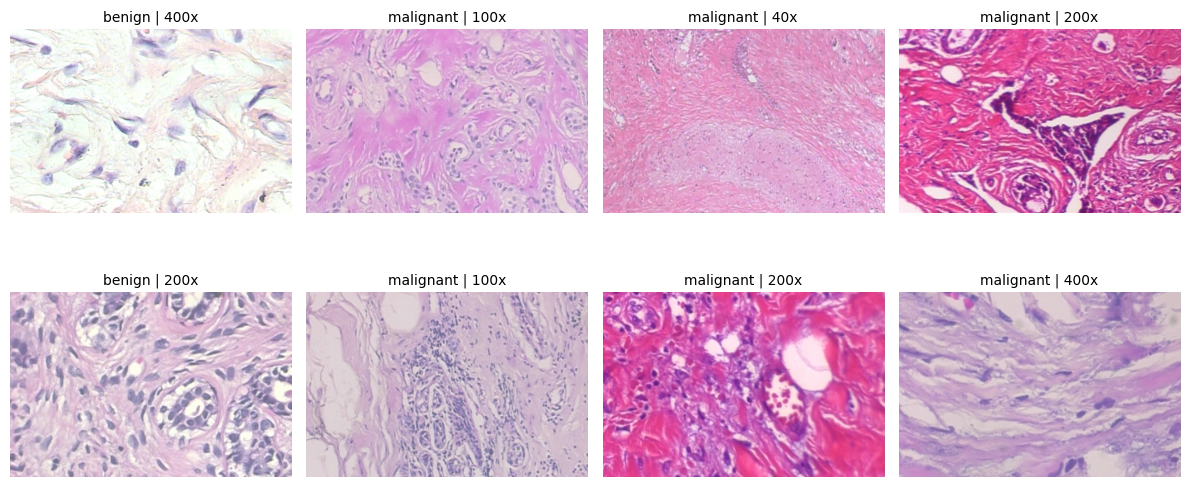

In [3]:
# Sample 8 random images
sample_df = metadata.sample(8, random_state=0).reset_index(drop=True)

# Create figure
fig, axes = plt.subplots(2, 4, figsize=(12, 6))

for i, ax in enumerate(axes.flat):
    row = sample_df.iloc[i]
    img = Image.open(row['filepath'])
    ax.imshow(img)
    ax.set_title(f"{row['tumor_class']} | {row['mag']}x", fontsize=10)
    ax.axis("off")

plt.tight_layout()
plt.show()


#### Create a Dataset class  
The `BreakHisDataset` class is a custom PyTorch `Dataset` designed to connect image files and metadata. It reads the DataFrame containing image paths and tumor labels, loads each image from disk using the Python Imaging Library (PIL), converts it to RGB format, and applies the specified data transformations (such as resizing, normalization, and augmentation). The class returns each sample as a tuple `(image_tensor, label_tensor)`, where the label is encoded as `0` for benign and `1` for malignant. This structure allows seamless batching and shuffling through PyTorch’s `DataLoader`.

In [4]:
class BreakHisDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img = Image.open(row['filepath']).convert('RGB')
        if self.transform:
            img = self.transform(img)
        label = 1 if row['tumor_class'].lower() == 'malignant' else 0
        return img, torch.tensor(label, dtype=torch.long)

#### Transforms
Transformation pipelines define how images are preprocessed before being fed into the neural network. For training data, the pipeline includes resizing to a fixed size (224×224 pixels), random horizontal flipping, random rotation, and tensor conversion. These augmentations increase dataset diversity and help the model generalize better by simulating natural image variability. For validation and test data, only resizing and tensor conversion are applied to ensure consistent evaluation without introducing random perturbations.

In [5]:
train_tfms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
])

val_tfms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

#### Data Splitting and Stratification  
To ensure robust model evaluation, the dataset was divided into three subsets: **training**, **validation**, and **test**. Approximately 50% of the images were allocated to training, 15% to validation, and 35% to testing. The splits were performed using *stratified sampling* to preserve the class distribution across subsets. Stratification was applied jointly on the `tumor_class` (benign or malignant) and `mag` (magnification level) columns by creating a combined stratification key (e.g., `malignant_200`). This approach maintains consistent proportions of both tumor type and magnification across all data partitions, reducing sampling bias and improving the reliability of model performance assessment.


In [6]:
# Create a combined stratification label (e.g., "benign_40")
metadata['stratify_key'] = metadata['tumor_class'].astype(str) + "_" + metadata['mag'].astype(str)

# First split: train+val vs test
train_val_df, test_df = train_test_split(
    metadata,
    test_size=0.35,
    stratify=metadata['stratify_key'],
    random_state=0
)

# Second split: train vs val (from the remaining 85%)
train_df, val_df = train_test_split(
    train_val_df,
    test_size=0.15 / 0.65,  # keep ~15% total for val
    stratify=train_val_df['stratify_key'],
    random_state=0
)

# Display counts
print(f"Train: {len(train_df)} | Val: {len(val_df)} | Test: {len(test_df)}\n")
print('Set', ['Malignant', 'Benign'])
print('Train', train_df['tumor_class'].value_counts().values)
print('Val', val_df['tumor_class'].value_counts().values)
print('Test', test_df['tumor_class'].value_counts().values)


Train: 1976 | Val: 594 | Test: 1384

Set ['Malignant', 'Benign']
Train [1351  625]
Val [406 188]
Test [946 438]


#### Class Weights

The BreakHis dataset exhibits a **class imbalance** between benign and malignant samples — one class contains significantly more images than the other.  
This imbalance can cause the model to become biased toward the majority class, leading to poor generalization and reduced sensitivity to the minority class.  

To address this, a **weighted cross-entropy loss** is used. 
Weights are computed inversely proportional to class frequencies, giving higher importance to the underrepresented class. 
This ensures that the model penalizes misclassifications of minority samples more strongly, promoting balanced learning across both classes.
To prevent any data leakage, weights are computed on the train set. 

In [7]:
# Count number of samples per class
counts = train_df['tumor_class'].value_counts().sort_index()
print(counts)

# Inverse frequency weighting
weights = 1.0 / torch.tensor(counts.values, dtype=torch.float)
weights = weights / weights.sum()  # normalize to sum 1
print("Class weights:", weights)

tumor_class
benign        625
malignant    1351
Name: count, dtype: int64
Class weights: tensor([0.6837, 0.3163])


#### DataLoaders  
After splitting the dataset into training, validation, and test sets, PyTorch **DataLoaders** were created for each subset. The training DataLoader shuffles the data to ensure that the model sees images in a different order each epoch, which improves generalization. Validation and test DataLoaders do not shuffle to maintain consistent evaluation. A batch size of 32 is used for all loaders, balancing memory usage and training efficiency. Multiple worker processes are employed to accelerate data loading. These DataLoaders provide batches of `(image, label)` tuples to feed into the model during training and evaluation.

In [8]:
# Define datasets with transforms
train_ds = BreakHisDataset(train_df, transform=train_tfms)
val_ds = BreakHisDataset(val_df, transform=val_tfms)
test_ds = BreakHisDataset(test_df, transform=val_tfms)

# Define DataLoaders
train_dl = DataLoader(train_ds, batch_size=16, shuffle=True, num_workers=0)
val_dl = DataLoader(val_ds, batch_size=16, shuffle=False, num_workers=0)
test_dl = DataLoader(test_ds, batch_size=16, shuffle=False, num_workers=0)

# Quick sanity check
print(f"Train batches: {len(train_dl)}, Validation batches: {len(val_dl)}, Test batches: {len(test_dl)}")


Train batches: 124, Validation batches: 38, Test batches: 87


## 1. Baseline convolutional neural network

#### Model Definition  
A convolutional neural network (CNN) was implemented to perform binary classification of tumor images. The network consists of three convolutional blocks, each including a convolutional layer, ReLU activation, and max-pooling to progressively extract hierarchical image features. The output of the convolutional layers is flattened and passed through a fully connected classifier with one hidden layer, culminating in an output layer of size two for the benign and malignant classes. This simple architecture is suitable for training from scratch on the BreakHis dataset while maintaining manageable computational requirements, and it provides a foundation for experimenting with more advanced models or transfer learning approaches.

In [9]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 28 * 28, 256), nn.ReLU(),
            nn.Linear(256, 2)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x


#### Early Stopping  
To prevent overfitting and reduce unnecessary training time, an **EarlyStopper** mechanism was implemented. Early stopping monitors the validation loss after each epoch and stops training if the loss does not improve for a specified number of consecutive epochs (patience). A minimum improvement threshold (`min_delta`) ensures that only meaningful decreases in validation loss reset the patience counter. This approach helps preserve the best-performing model based on validation performance, improving generalization to unseen data.

In addition to stopping training early, the implementation stores a deep copy of the **best-performing model weights** whenever a new minimum validation loss is reached. Once training concludes, the model can be restored to this best state to guarantee that further epochs without improvement do not degrade performance. This makes the early stopping mechanism both efficient and reliable for model selection.


In [10]:
class EarlyStopper:
    def __init__(self, patience=5, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = np.inf
        self.should_stop = False
        self.best_model_wts = None

    def __call__(self, val_loss, model):
        # Check if validation loss improved
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
            # Deep copy best model weights
            self.best_model_wts = copy.deepcopy(model.state_dict())
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.should_stop = True

    def restore_best_weights(self, model):
        if self.best_model_wts is not None:
            model.load_state_dict(self.best_model_wts)

#### Training Loop  
The training loop iteratively updates the model weights using the **Adam optimizer** and **cross-entropy loss** for binary classification. For each epoch, the model performs a forward pass on training batches, computes the loss, performs backpropagation, and updates parameters. After training, the model is evaluated on the validation set to calculate validation loss and accuracy. The EarlyStopper monitors validation loss, and training stops automatically if no improvement is observed for the specified patience. Metrics are logged per epoch, allowing visualization of training progress and early identification of overfitting.

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleCNN().to(device)
criterion = nn.CrossEntropyLoss(weight=weights.to(device))
optimizer = optim.Adam(model.parameters(), lr=1e-4)
early_stopper = EarlyStopper(patience=5)

for epoch in range(30):
    # Training
    model.train()
    train_loss = 0
    for imgs, labels in train_dl:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    # Validation
    model.eval()
    val_loss = 0
    val_preds, val_labels = [], []
    correct = 0
    total = 0
    with torch.no_grad():
        for imgs, labels in val_dl:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            preds = outputs.argmax(dim=1) # Get prediction
            val_preds.extend(preds) # Store prediction
            val_labels.extend(labels.cpu().numpy()) # Store label
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    avg_train = train_loss / len(train_dl)
    avg_val = val_loss / len(val_dl)
    val_acc = correct / total
    val_bal_acc = balanced_accuracy_score(val_labels, val_preds)
    print(f"Epoch {epoch+1}: train_loss={avg_train:.4f}, val_loss={avg_val:.4f}, val_acc={val_acc:.3f}, val_bal_acc={val_bal_acc:.3f}")

    early_stopper(avg_val, model)
    if early_stopper.should_stop:
        print("Early stopping triggered.")
        break


Epoch 1: train_loss=0.6052, val_loss=0.5054, val_acc=0.791, val_bal_acc=0.797
Epoch 2: train_loss=0.5134, val_loss=0.4540, val_acc=0.867, val_bal_acc=0.831
Epoch 3: train_loss=0.4828, val_loss=0.4602, val_acc=0.872, val_bal_acc=0.821
Epoch 4: train_loss=0.4708, val_loss=0.4069, val_acc=0.864, val_bal_acc=0.833
Epoch 5: train_loss=0.4652, val_loss=0.4105, val_acc=0.870, val_bal_acc=0.835
Epoch 6: train_loss=0.4532, val_loss=0.4154, val_acc=0.842, val_bal_acc=0.834
Epoch 7: train_loss=0.4363, val_loss=0.3968, val_acc=0.850, val_bal_acc=0.836
Epoch 8: train_loss=0.4404, val_loss=0.3910, val_acc=0.877, val_bal_acc=0.840
Epoch 9: train_loss=0.4453, val_loss=0.3825, val_acc=0.859, val_bal_acc=0.841
Epoch 10: train_loss=0.4231, val_loss=0.4426, val_acc=0.810, val_bal_acc=0.817
Epoch 11: train_loss=0.4242, val_loss=0.3792, val_acc=0.877, val_bal_acc=0.846
Epoch 12: train_loss=0.4119, val_loss=0.3697, val_acc=0.864, val_bal_acc=0.849
Epoch 13: train_loss=0.4125, val_loss=0.3738, val_acc=0.867, 

#### Model Evaluation on Test Set  
After training, the best model weights (based on minimum validation loss) were restored and evaluated on the held-out test set to measure generalization performance. The evaluation included multiple complementary metrics: **balanced accuracy** to account for class imbalance, **precision**, **recall**, and **F1-score** to assess classification quality, and **ROC-AUC** to measure the model’s ability to separate the two tumor classes across thresholds. A confusion matrix was also plotted to visualize correct and incorrect predictions. Together, these metrics provide a comprehensive understanding of model performance on unseen data.


Balanced Accuracy: 0.827
Precision: 0.885
Recall: 0.910
F1-score: 0.897
ROC-AUC: 0.903

Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.74      0.77       438
           1       0.88      0.91      0.90       946

    accuracy                           0.86      1384
   macro avg       0.84      0.83      0.83      1384
weighted avg       0.86      0.86      0.86      1384



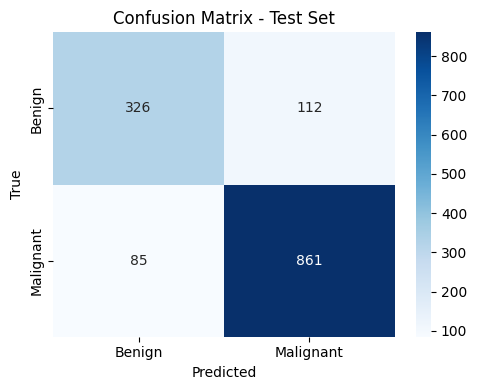

In [12]:
# Restore best weights
early_stopper.restore_best_weights(model)
model.eval()

all_preds, all_labels, all_probs = [], [], []

with torch.no_grad():
    for imgs, labels in test_dl:
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model(imgs)
        probs = torch.softmax(outputs, dim=1)[:, 1].cpu().numpy()
        preds = outputs.argmax(dim=1).cpu().numpy()
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds)
        all_probs.extend(probs)

# Compute metrics
bal_acc = balanced_accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds)
recall = recall_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds)
roc = roc_auc_score(all_labels, all_probs)

print(f"Balanced Accuracy: {bal_acc:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1-score: {f1:.3f}")
print(f"ROC-AUC: {roc:.3f}")
print("\nClassification Report:\n", classification_report(all_labels, all_preds))

# Store metrics for later comparison
model_metrics = {}
model_metrics["CNN_baseline"] = {
    "balanced_accuracy": bal_acc,
    "f1_score": f1,
    "roc_auc": roc,
    "precision": precision,
    "recall": recall
}

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Benign", "Malignant"],
            yticklabels=["Benign", "Malignant"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - Test Set")
plt.tight_layout()
plt.show()

## 2. Fine-Tuning a Pretrained Model  
To improve performance, transfer learning was applied using a pretrained **ResNet-18** model trained on the ImageNet dataset. All convolutional layers were initially frozen to preserve learned visual features, and only the final classification head was replaced and trained for the binary tumor classification task. The last convolutional block was later unfrozen for fine-tuning, allowing the model to adapt high-level features to the BreakHis dataset. This approach accelerates convergence, reduces training time, and improves accuracy compared to training from scratch, especially with limited data.


#### Load Pretrained Model and Replace Classifier  
A ResNet-18 pretrained on ImageNet is loaded. Its final fully connected layer is replaced with a new linear layer suitable for the binary classification task (benign vs malignant). This step ensures the model outputs the correct number of classes while retaining general visual features learned during pretraining.


In [13]:
torch.manual_seed(0)

# Load a ResNet-18 model pretrained on ImageNet
# The pretrained weights help initialize the model with strong general features
model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)

# Get the number of input features to the final fully connected layer
num_ftrs = model.fc.in_features

# Replace the classifier head with a new one for 2-class output
# (benign vs malignant)
model.fc = nn.Linear(num_ftrs, 2)

#### Device Setup  
The model is moved to the appropriate device (`CPU` or `GPU`) to accelerate computation. This step ensures that all subsequent computations, including training and evaluation, are performed on the selected hardware.


In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

### Phase 1 — Feature Extraction  
All convolutional layers are frozen so only the newly added classifier head is trainable. This allows the model to leverage pretrained features while quickly learning to map them to the tumor classification task. Loss and optimizer are defined to update only the head’s parameters.


In [15]:
# Freeze all convolutional layers so only the new classifier head trains
for param in model.parameters():
    param.requires_grad = False
for param in model.fc.parameters():
    param.requires_grad = True

# Define loss and optimizer for the head only
criterion = nn.CrossEntropyLoss(weight=weights.to(device))
optimizer = optim.Adam(model.fc.parameters(), lr=1e-3)

#### Train Classifier Head  
The classifier head is trained for a few epochs while the backbone remains frozen. Validation is performed each epoch to monitor performance and compute metrics like balanced accuracy. This phase allows the model to adapt high-level features to the specific task without disturbing pretrained weights.


In [16]:
# Early stopper for head training
head_early_stopper = EarlyStopper(patience=3)  # stop if val loss doesn't improve for 3 epochs
max_epochs_head = 20  # upper limit to avoid endless training

for epoch in range(1, max_epochs_head + 1):
    model.train()
    train_loss = 0
    all_preds, all_labels = [], []

    # --- Training ---
    for imgs, labels in train_dl:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    # --- Validation ---
    model.eval()
    val_loss = 0
    val_preds, val_labels = [], []
    with torch.no_grad():
        for imgs, labels in val_dl:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            preds = outputs.argmax(dim=1).cpu().numpy()
            val_preds.extend(preds)
            val_labels.extend(labels.cpu().numpy())

    avg_train = train_loss / len(train_dl)
    avg_val = val_loss / len(val_dl)
    val_bal_acc = balanced_accuracy_score(val_labels, val_preds)

    print(f"Epoch {epoch}: train_loss={avg_train:.4f}, val_loss={avg_val:.4f}, val_bal_acc={val_bal_acc:.3f}")

    # --- Early stopping check ---
    head_early_stopper(avg_val, model)
    if head_early_stopper.should_stop:
        print("Early stopping triggered for head training.")
        break

# After loop, the model has the **best-performing head weights** ready for fine-tuning
head_early_stopper.restore_best_weights(model)
print("Head training completed. Best validation weights restored.")


Epoch 1: train_loss=0.5922, val_loss=0.5011, val_bal_acc=0.761
Epoch 2: train_loss=0.4726, val_loss=0.4127, val_bal_acc=0.817
Epoch 3: train_loss=0.4265, val_loss=0.3817, val_bal_acc=0.832
Epoch 4: train_loss=0.4395, val_loss=0.3660, val_bal_acc=0.841
Epoch 5: train_loss=0.4179, val_loss=0.4057, val_bal_acc=0.823
Epoch 6: train_loss=0.3979, val_loss=0.3623, val_bal_acc=0.842
Epoch 7: train_loss=0.3804, val_loss=0.3933, val_bal_acc=0.808
Epoch 8: train_loss=0.3634, val_loss=0.3739, val_bal_acc=0.827
Epoch 9: train_loss=0.3565, val_loss=0.3621, val_bal_acc=0.846
Epoch 10: train_loss=0.3575, val_loss=0.3638, val_bal_acc=0.834
Epoch 11: train_loss=0.3700, val_loss=0.3537, val_bal_acc=0.836
Epoch 12: train_loss=0.3740, val_loss=0.3302, val_bal_acc=0.856
Epoch 13: train_loss=0.3470, val_loss=0.3360, val_bal_acc=0.856
Epoch 14: train_loss=0.3733, val_loss=0.3428, val_bal_acc=0.862
Epoch 15: train_loss=0.3669, val_loss=0.3358, val_bal_acc=0.858
Early stopping triggered for head training.
Head 

### Phase 2 — Fine-Tuning  
Selected layers of the pretrained backbone (e.g., the last convolutional block) are unfrozen. An optimizer with differential learning rates is set: a smaller learning rate for the backbone and a higher one for the classifier head. Optional learning rate scheduling is used to improve convergence. This phase enables the model to adjust high-level feature representations to the domain-specific data.


In [17]:
# Unfreeze the last convolutional block (layer4) for fine-tuning
for param in model.layer4.parameters():
    param.requires_grad = True

# Define an optimizer with differential learning rates:
#  - lower lr for pretrained backbone
#  - higher lr for classifier head
optimizer = optim.Adam([
    {"params": model.layer4.parameters(), "lr": 1e-5},
    {"params": model.fc.parameters(), "lr": 1e-4}
])

# Use a learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5)

#### Fine-Tuning Training Loop  
The model is trained with the unfrozen layers while monitoring validation performance. Early stopping is used to halt training when validation loss stops improving, and the best-performing model weights are stored. Training metrics are tracked, and validation metrics, including balanced accuracy, are computed each epoch.


In [18]:
num_epochs_ft = 30
early_stopper = EarlyStopper(patience=5)

for epoch in range(1, num_epochs_ft + 1):
    model.train()
    train_loss = 0
    all_preds, all_labels = [], []

    for imgs, labels in train_dl:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    # --- Validation phase ---
    model.eval()
    val_loss = 0
    val_preds, val_labels = [], []
    with torch.no_grad():
        for imgs, labels in val_dl:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            preds = outputs.argmax(dim=1).cpu().numpy()
            val_preds.extend(preds)
            val_labels.extend(labels.cpu().numpy())

    avg_train = train_loss / len(train_dl)
    avg_val = val_loss / len(val_dl)
    val_bal_acc = balanced_accuracy_score(val_labels, val_preds)

    print(f"Epoch {epoch}: train_loss={avg_train:.4f}, val_loss={avg_val:.4f}, val_bal_acc={val_bal_acc:.3f}")

    # Scheduler step and early stopping
    scheduler.step(avg_val)
    early_stopper(avg_val, model)
    if early_stopper.should_stop:
        print("Early stopping triggered.")
        break

Epoch 1: train_loss=0.3316, val_loss=0.3133, val_bal_acc=0.856
Epoch 2: train_loss=0.2926, val_loss=0.2778, val_bal_acc=0.885
Epoch 3: train_loss=0.2586, val_loss=0.2666, val_bal_acc=0.896
Epoch 4: train_loss=0.2324, val_loss=0.2513, val_bal_acc=0.910
Epoch 5: train_loss=0.2352, val_loss=0.2328, val_bal_acc=0.914
Epoch 6: train_loss=0.1954, val_loss=0.2156, val_bal_acc=0.924
Epoch 7: train_loss=0.1744, val_loss=0.1958, val_bal_acc=0.931
Epoch 8: train_loss=0.1744, val_loss=0.1857, val_bal_acc=0.937
Epoch 9: train_loss=0.1439, val_loss=0.1918, val_bal_acc=0.937
Epoch 10: train_loss=0.1525, val_loss=0.1997, val_bal_acc=0.934
Epoch 11: train_loss=0.1390, val_loss=0.1759, val_bal_acc=0.928
Epoch 12: train_loss=0.1298, val_loss=0.1735, val_bal_acc=0.933
Epoch 13: train_loss=0.1208, val_loss=0.1712, val_bal_acc=0.931
Epoch 14: train_loss=0.1102, val_loss=0.1675, val_bal_acc=0.943
Epoch 15: train_loss=0.0987, val_loss=0.1728, val_bal_acc=0.942
Epoch 16: train_loss=0.1055, val_loss=0.1636, val

### Phase 3 — Evaluation on Test Set  
After training, the model is restored to the weights corresponding to the best validation performance. The model is evaluated on the test set using multiple metrics, such as balanced accuracy, precision, recall, F1-score, ROC-AUC, and a confusion matrix. This provides a comprehensive assessment of generalization performance on unseen data.

Balanced Accuracy: 0.956
Precision: 0.972
Recall: 0.970
F1-score: 0.971
ROC-AUC: 0.991

Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.94      0.94       438
           1       0.97      0.97      0.97       946

    accuracy                           0.96      1384
   macro avg       0.95      0.96      0.95      1384
weighted avg       0.96      0.96      0.96      1384



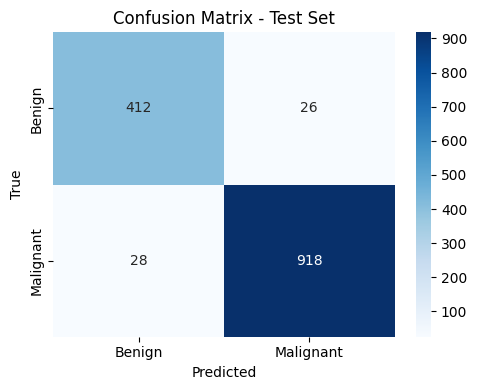

In [19]:
# Restore best weights
early_stopper.restore_best_weights(model)
model.eval()

all_preds, all_labels, all_probs = [], [], []

with torch.no_grad():
    for imgs, labels in test_dl:
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model(imgs)
        probs = torch.softmax(outputs, dim=1)[:, 1].cpu().numpy()
        preds = outputs.argmax(dim=1).cpu().numpy()
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds)
        all_probs.extend(probs)

# Compute metrics
bal_acc = balanced_accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds)
recall = recall_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds)
roc = roc_auc_score(all_labels, all_probs)

print(f"Balanced Accuracy: {bal_acc:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1-score: {f1:.3f}")
print(f"ROC-AUC: {roc:.3f}")
print("\nClassification Report:\n", classification_report(all_labels, all_preds))

# Store metrics for later comparison
model_metrics["ResNet18_finetuned"] = {
    "balanced_accuracy": bal_acc,
    "f1_score": f1,
    "roc_auc": roc,
    "precision": precision,
    "recall": recall
}

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Benign", "Malignant"],
            yticklabels=["Benign", "Malignant"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - Test Set")
plt.tight_layout()
plt.show()


## 3. Incorporating Magnification Through FiLM Modulation

In the BreakHis dataset, each microscopic image is captured at a specific **magnification level** (e.g., 40×, 100×, 200×, 400×). While this magnification value does **not directly indicate whether a tumor is benign or malignant**, it significantly influences how cellular structures and textures appear. Differences in magnification affect feature scale, sharpness, and visible cellular detail, which can cause a deep learning model to misinterpret patterns if not properly accounted for. Thus, incorporating magnification as contextual information helps the model adjust its internal representations, improving robustness across optical settings.

To achieve this, magnification can be integrated using a **Feature-wise Linear Modulation (FiLM)** mechanism. The FiLM approach modulates the intermediate activations of the ResNet backbone itself. Each magnification level is encoded as a learnable embedding vector, which is passed through small linear layers to produce scaling (γ) and shifting (β) coefficients. These parameters are applied to the feature maps within the network, effectively conditioning the convolutional filters on the magnification context. In this way, the network dynamically adjusts how it processes textures and structures depending on the optical scale, leading to a more adaptable and generalizable tumor classification model.


#### New Dataset Class Implementation

As this new model takes as image the image and the magnification information, the custom Dataset class must be modified. As before, this new `BreakHisDataset` class is a custom PyTorch dataset designed to interface the BreakHis image metadata with the deep learning pipeline. 
It reads image file paths and associated metadata from a DataFrame, loads each image from disk, applies transformations (e.g., resizing, normalization, augmentation), and returns a triplet:  
the transformed image tensor, the tumor class label (0 for benign, 1 for malignant), and the encoded magnification index.

This new implementation ensures that all images are converted to tensors suitable for PyTorch models, while categorical metadata such as magnification is encoded numerically to be used as an auxiliary input feature. 
It also supports flexible magnification mapping (`mag_to_idx`) to maintain consistency between training, validation, and test splits. 
By integrating both visual and metadata information, this dataset class provides a complete, structured input for multimodal deep learning models.


In [20]:
class BreakHisDataset(Dataset):
    def __init__(self, df, transform=None, mag_to_idx=None):
        """
        Args:
            df (pd.DataFrame): metadata dataframe with columns ['filename', 'tumor_class', 'mag']
            transform: torchvision transforms to apply to images
            mag_to_idx (dict): mapping of magnification values to integer indices
        """
        self.df = df.reset_index(drop=True)
        self.transform = transform
        # Create mapping if not provided
        if mag_to_idx is None:
            unique_mags = sorted(df['mag'].unique())
            self.mag_to_idx = {mag: i for i, mag in enumerate(unique_mags)}
        else:
            self.mag_to_idx = mag_to_idx
        
        # Encode magnification indices
        self.df['mag_idx'] = self.df['mag'].map(self.mag_to_idx)
        # Encode labels as integers (0=benign, 1=malignant)
        self.label_to_idx = {'benign': 0, 'malignant': 1}
        self.df['label_idx'] = self.df['tumor_class'].map(self.label_to_idx)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img = Image.open(row['filepath']).convert('RGB')
        label = torch.tensor(row['label_idx'], dtype=torch.long)
        mag_idx = torch.tensor(row['mag_idx'], dtype=torch.long)
        
        if self.transform:
            img = self.transform(img)
        
        return img, label, mag_idx


#### Dataloaders

In [21]:
# 1. Create shared magnification mapping
unique_mags = sorted(metadata["mag"].unique())
mag_to_idx = {mag: i for i, mag in enumerate(unique_mags)}
print("Magnification mapping:", mag_to_idx)

# 2. Define datasets with transforms and magnification support
train_ds = BreakHisDataset(train_df, transform=train_tfms, mag_to_idx=mag_to_idx)
val_ds   = BreakHisDataset(val_df, transform=val_tfms,   mag_to_idx=mag_to_idx)
test_ds  = BreakHisDataset(test_df, transform=val_tfms,   mag_to_idx=mag_to_idx)

# 3. Define DataLoaders
train_dl = DataLoader(train_ds, batch_size=16, shuffle=True,  num_workers=0)
val_dl   = DataLoader(val_ds,   batch_size=16, shuffle=False, num_workers=0)
test_dl  = DataLoader(test_ds,  batch_size=16, shuffle=False, num_workers=0)

# 4. Quick sanity check
print(f"Train batches: {len(train_dl)}, Validation batches: {len(val_dl)}, Test batches: {len(test_dl)}")

# Optional: inspect one batch
imgs, labels, mags = next(iter(train_dl))
print(f"Image batch: {imgs.shape}, Labels: {labels.shape}, Mags: {mags.shape}")
print(f"Unique magnifications in batch: {mags.unique().tolist()}")

Magnification mapping: {np.int64(40): 0, np.int64(100): 1, np.int64(200): 2, np.int64(400): 3}
Train batches: 124, Validation batches: 38, Test batches: 87
Image batch: torch.Size([16, 3, 224, 224]), Labels: torch.Size([16]), Mags: torch.Size([16])
Unique magnifications in batch: [0, 1, 2, 3]


#### FiLM Block

The **FiLM (Feature-wise Linear Modulation)** block enables the model to adapt its internal representations based on the magnification level of each image.  
While magnification itself does not directly determine the tumor class, it affects image texture and resolution — factors that influence how visual features should be interpreted.  

The block learns two modulation parameters for each magnification level:  
- **γ (gamma)**: a scaling factor that amplifies or attenuates feature maps.  
- **β (beta)**: a shifting factor that adjusts feature activations.  

During the forward pass, the magnification index is first transformed into an embedding vector.  
This embedding is then passed through two small fully connected layers to produce γ and β, which are applied element-wise to the CNN feature maps.  
As a result, the same ResNet backbone dynamically adapts its feature extraction depending on the image


In [22]:
class FiLMBlock(nn.Module):
    def __init__(self, num_mags: int, n_channels: int, emb_dim: int = 8):
        """
        Args:
            num_mags (int): number of distinct magnification levels
            n_channels (int): number of feature channels to modulate
            emb_dim (int): embedding dimension for magnification encoding
        """
        super().__init__()
        self.embed = nn.Embedding(num_mags, emb_dim)
        self.fc_gamma = nn.Linear(emb_dim, n_channels)
        self.fc_beta = nn.Linear(emb_dim, n_channels)

    def forward(self, x, mag_idx):
        """
        x: [B, C, H, W] feature maps
        mag_idx: [B] long tensor of magnification indices
        """
        e = self.embed(mag_idx)                    # [B, emb_dim]
        gamma = self.fc_gamma(e).unsqueeze(-1).unsqueeze(-1)  # [B, C, 1, 1]
        beta = self.fc_beta(e).unsqueeze(-1).unsqueeze(-1)    # [B, C, 1, 1]
        return gamma * x + beta

#### ResNet18 with FiLM Modulation

This model extends the standard **ResNet18** architecture by integrating **FiLM modulation** at specific feature extraction layers.  
The goal is to allow the network to **adapt its learned representations** according to the magnification level without training separate models for each scale.

The backbone (pretrained on ImageNet) processes the image through its standard convolutional and residual layers.  
Two FiLM blocks are strategically inserted after the **third** and **fourth** residual stages — the deeper layers where abstract visual patterns are formed.  
At these points, the FiLM blocks receive the magnification index and generate corresponding **γ (scale)** and **β (shift)** values that modulate the feature maps.  

This conditional modulation makes the feature extractor more flexible:  
it can recalibrate its filters to handle the texture and detail variations across different magnifications, while still sharing most of its weights across all scales.  
After feature extraction, the network performs global average pooling and classification as in standard ResNet18.


In [23]:
class ResNet18FiLM(nn.Module):
    def __init__(self, num_classes: int, num_mags: int, emb_dim: int = 8):
        """
        Combines pretrained ResNet18 with FiLM conditional modulation.
        """
        super().__init__()
        base = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
        self.features = nn.Sequential(*(list(base.children())[:-2]))  # up to last conv block
        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(base.fc.in_features, num_classes)

        # Insert FiLM blocks after deeper layers
        self.film3 = FiLMBlock(num_mags, n_channels=256, emb_dim=emb_dim)
        self.film4 = FiLMBlock(num_mags, n_channels=512, emb_dim=emb_dim)

    def forward(self, x_img, x_mag):
        """
        x_img: image tensor [B, 3, 224, 224]
        x_mag: magnification indices [B]
        """
        # replicate ResNet forward up to layers 3 and 4
        x = self.features[0](x_img)  # conv1
        x = self.features[1](x)      # bn1
        x = self.features[2](x)      # relu
        x = self.features[3](x)      # maxpool

        # layer1, layer2 normal
        x = self.features[4](x)
        x = self.features[5](x)

        # layer3 modulated
        x = self.features[6](x)
        x = self.film3(x, x_mag)

        # layer4 modulated
        x = self.features[7](x)
        x = self.film4(x, x_mag)

        # global pooling and classifier
        x = self.pool(x)
        x = torch.flatten(x, 1)
        out = self.fc(x)
        return out

#### Implement model and loss

In [24]:
num_classes = 2
num_mags = metadata["mag"].nunique()
model = ResNet18FiLM(num_classes=num_classes, num_mags=num_mags).to(device)

criterion = nn.CrossEntropyLoss(weight=weights)

### Phase 1 — Train FiLM Blocks and Classifier Head

In this first training phase, the convolutional backbone of ResNet18 is **frozen** so that only the **FiLM layers** and the **final classifier** are updated.  
This ensures that the pretrained convolutional filters from ImageNet remain stable, while the FiLM blocks learn how to **adapt the feature activations** according to the magnification level.

The optimizer is configured to include only the parameters of the FiLM and classifier layers, preventing unnecessary gradient computation for the frozen backbone.  
A **learning rate scheduler** monitors the validation loss and reduces the learning rate when it plateaus, helping refine convergence.  
An **early stopping mechanism** halts training if no validation improvement is observed for several epochs, avoiding overfitting.

This phase focuses on learning how magnification affects high-level feature representations without altering the base visual extractor.


In [25]:
# Only FiLM layers and classifier will be trained.
for p in model.features.parameters():
    p.requires_grad = False

# Optimizer only sees FiLM + classifier parameters
optimizer = optim.Adam(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=1e-3, weight_decay=1e-5
)

# LR scheduler: reduces LR if val loss plateaus
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

# Early stopping: stop if no improvement for 5 epochs
early_stopper = EarlyStopper(patience=5)

#### Training

In [26]:
num_epochs = 20
for epoch in range(1, num_epochs + 1):
    model.train()
    train_loss, val_loss = 0, 0
    train_preds, train_labels = [], []
    val_preds, val_labels = [], []

    # --- Training ---
    for imgs, labels, mags in train_dl:
        imgs, labels, mags = imgs.to(device), labels.to(device), mags.to(device)
        optimizer.zero_grad()
        outputs = model(imgs, mags)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        preds = outputs.argmax(dim=1)
        train_preds.extend(preds.cpu().numpy())
        train_labels.extend(labels.cpu().numpy())

    # --- Validation ---
    model.eval()
    with torch.no_grad():
        for imgs, labels, mags in val_dl:
            imgs, labels, mags = imgs.to(device), labels.to(device), mags.to(device)
            outputs = model(imgs, mags)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            preds = outputs.argmax(dim=1)
            val_preds.extend(preds.cpu().numpy())
            val_labels.extend(labels.cpu().numpy())

    # --- METRICS & LOGGING ---
    avg_train = train_loss / len(train_dl)
    avg_val = val_loss / len(val_dl)
    bal_acc = balanced_accuracy_score(val_labels, val_preds)

    print(f"Epoch {epoch}: train_loss={avg_train:.4f}, val_loss={avg_val:.4f}, val_bal_acc={bal_acc:.3f}")

    # --- LR Scheduling & Early Stopping ---
    scheduler.step(avg_val)
    early_stopper(avg_val, model)
    if early_stopper.should_stop:
        print("Early stopping triggered (Phase 1).")
        break

# Restore best model
early_stopper.restore_best_weights(model)

Epoch 1: train_loss=0.7086, val_loss=0.6125, val_bal_acc=0.692
Epoch 2: train_loss=0.6160, val_loss=0.8165, val_bal_acc=0.702
Epoch 3: train_loss=0.6151, val_loss=0.5336, val_bal_acc=0.780
Epoch 4: train_loss=0.5405, val_loss=0.5475, val_bal_acc=0.785
Epoch 5: train_loss=0.5163, val_loss=0.5447, val_bal_acc=0.767
Epoch 6: train_loss=0.5254, val_loss=0.4703, val_bal_acc=0.805
Epoch 7: train_loss=0.4658, val_loss=0.4667, val_bal_acc=0.784
Epoch 8: train_loss=0.4938, val_loss=0.5117, val_bal_acc=0.785
Epoch 9: train_loss=0.4741, val_loss=0.4342, val_bal_acc=0.822
Epoch 10: train_loss=0.4506, val_loss=0.5143, val_bal_acc=0.819
Epoch 11: train_loss=0.4529, val_loss=0.4208, val_bal_acc=0.811
Epoch 12: train_loss=0.4366, val_loss=0.5155, val_bal_acc=0.810
Epoch 13: train_loss=0.4170, val_loss=0.3459, val_bal_acc=0.867
Epoch 14: train_loss=0.4072, val_loss=0.3112, val_bal_acc=0.876
Epoch 15: train_loss=0.4226, val_loss=0.4381, val_bal_acc=0.820
Epoch 16: train_loss=0.4189, val_loss=0.3326, val

### Phase 2 — Fine-Tuning the Full Model

After the FiLM layers and classifier head have been trained, the second phase unfreezes the **entire ResNet18 backbone**.  
This enables the model to perform **end-to-end fine-tuning**, allowing lower convolutional layers to adjust slightly to the BreakHis dataset while preserving previously learned visual priors from ImageNet.

All parameters, including those of the FiLM blocks, backbone, and classifier, are now trainable.  
A new optimizer is initialized with a **smaller learning rate**, ensuring that fine-tuning proceeds gradually to avoid destabilizing pretrained weights.  
As before, a **ReduceLROnPlateau scheduler** adjusts the learning rate dynamically based on validation loss trends, and **early stopping** prevents overfitting by halting training when no further improvement occurs.

This phase refines the entire feature extraction process, aligning the pretrained filters with the histopathological image characteristics and the magnification-aware modulation learned through FiLM.


In [27]:
# --- UNFREEZE BACKBONE ---
# All parameters are now trainable (ResNet + FiLM + classifier)
for p in model.parameters():
    p.requires_grad = True

# Reinitialize optimizer for all parameters with smaller LR
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)
early_stopper = EarlyStopper(patience=5)

#### Training

In [28]:
num_epochs_ft = 30
for epoch in range(1, num_epochs_ft + 1):
    model.train()
    train_loss, val_loss = 0, 0
    val_preds, val_labels = [], []

    # --- Training ---
    for imgs, labels, mags in train_dl:
        imgs, labels, mags = imgs.to(device), labels.to(device), mags.to(device)
        optimizer.zero_grad()
        outputs = model(imgs, mags)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    # --- Validation ---
    model.eval()
    with torch.no_grad():
        for imgs, labels, mags in val_dl:
            imgs, labels, mags = imgs.to(device), labels.to(device), mags.to(device)
            outputs = model(imgs, mags)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            preds = outputs.argmax(dim=1)
            val_preds.extend(preds.cpu().numpy())
            val_labels.extend(labels.cpu().numpy())

    # --- METRICS & LOGGING ---
    avg_train = train_loss / len(train_dl)
    avg_val = val_loss / len(val_dl)
    val_bal_acc = balanced_accuracy_score(val_labels, val_preds)

    print(f"Epoch {epoch}: train_loss={avg_train:.4f}, val_loss={avg_val:.4f}, val_bal_acc={val_bal_acc:.3f}")

     # --- Scheduler + Early Stop ---
    scheduler.step(avg_val)
    early_stopper(avg_val, model)
    if early_stopper.should_stop:
        print("Early stopping triggered (Phase 2).")
        break

# Restore best fine-tuned model
early_stopper.restore_best_weights(model)
print("Training complete and best weights restored.")

Epoch 1: train_loss=0.5904, val_loss=0.5534, val_bal_acc=0.772
Epoch 2: train_loss=0.3759, val_loss=0.2248, val_bal_acc=0.921
Epoch 3: train_loss=0.3038, val_loss=0.2212, val_bal_acc=0.919
Epoch 4: train_loss=0.2922, val_loss=0.2034, val_bal_acc=0.924
Epoch 5: train_loss=0.2166, val_loss=0.2066, val_bal_acc=0.934
Epoch 6: train_loss=0.2024, val_loss=0.1547, val_bal_acc=0.950
Epoch 7: train_loss=0.1746, val_loss=0.2454, val_bal_acc=0.917
Epoch 8: train_loss=0.1652, val_loss=0.2959, val_bal_acc=0.885
Epoch 9: train_loss=0.1647, val_loss=0.2118, val_bal_acc=0.924
Epoch 10: train_loss=0.1214, val_loss=0.2571, val_bal_acc=0.930
Epoch 11: train_loss=0.0923, val_loss=0.1062, val_bal_acc=0.971
Epoch 12: train_loss=0.0797, val_loss=0.1029, val_bal_acc=0.969
Epoch 13: train_loss=0.0557, val_loss=0.0991, val_bal_acc=0.971
Epoch 14: train_loss=0.0620, val_loss=0.1296, val_bal_acc=0.950
Epoch 15: train_loss=0.0574, val_loss=0.1270, val_bal_acc=0.973
Epoch 16: train_loss=0.0449, val_loss=0.0852, val

### Phase 3 — Evaluation on Test Set
The model is evaluated on the test set using multiple metrics, such as balanced accuracy, precision, recall, F1-score, ROC-AUC, and a confusion matrix. This provides a comprehensive assessment of generalization performance on unseen data.

Balanced Accuracy: 0.967
Precision: 0.985
Recall: 0.965
F1-score: 0.975
ROC-AUC: 0.993

Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.97      0.95       438
           1       0.98      0.97      0.97       946

    accuracy                           0.97      1384
   macro avg       0.96      0.97      0.96      1384
weighted avg       0.97      0.97      0.97      1384



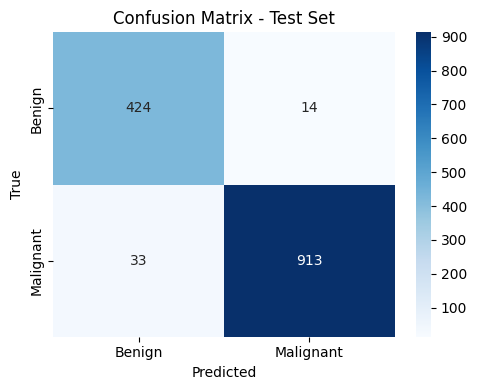

In [29]:
# ================================================================
# 8. Test Evaluation (with magnification embeddings)
# ================================================================
model.eval()

all_preds, all_labels, all_probs = [], [], []

with torch.no_grad():
    for imgs, labels, mags in test_dl:
        imgs, labels, mags = imgs.to(device), labels.to(device), mags.to(device)

        # Forward pass with magnification indices
        outputs = model(imgs, mags)
        probs = torch.softmax(outputs, dim=1)[:, 1].cpu().numpy()
        preds = outputs.argmax(dim=1).cpu().numpy()

        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds)
        all_probs.extend(probs)

# Compute metrics
bal_acc = balanced_accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds)
recall = recall_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds)
roc = roc_auc_score(all_labels, all_probs)

print(f"Balanced Accuracy: {bal_acc:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1-score: {f1:.3f}")
print(f"ROC-AUC: {roc:.3f}")
print("\nClassification Report:\n", classification_report(all_labels, all_preds))

# Store metrics for later comparison
model_metrics["FiLM_ResNet18"] = {
    "balanced_accuracy": bal_acc,
    "f1_score": f1,
    "roc_auc": roc,
    "precision": precision,
    "recall": recall
}

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Benign", "Malignant"],
            yticklabels=["Benign", "Malignant"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - Test Set")
plt.tight_layout()
plt.show()


## Conclusion

In [30]:
metrics_df = pd.DataFrame(model_metrics).T
display(metrics_df)

,balanced_accuracy,f1_score,roc_auc,precision,recall
CNN_baseline,0.827220,0.897342,0.902606,0.884892,0.910148
ResNet18_finetuned,0.955520,0.971429,0.991249,0.972458,0.970402
FiLM_ResNet18,0.966576,0.974907,0.993076,0.984898,0.965116


Across all experiments, progressively more sophisticated architectures yielded substantial performance gains.  
The **baseline CNN** achieved a balanced accuracy of 0.83, establishing a solid starting point but showing limitations in handling the dataset’s variability.  
Fine-tuning a **pretrained ResNet18** significantly improved results, reaching a balanced accuracy of 0.96 and a ROC-AUC above 0.99 — demonstrating the effectiveness of transfer learning for histopathology image classification.  

The best performance was obtained with the **FiLM-augmented ResNet18**, which integrates magnification-aware feature modulation.  
Although magnification itself does not directly determine the tumor class, conditioning intermediate feature representations through FiLM layers allowed the model to adapt its feature extraction process to the scale of observation.  
This yielded the highest overall metrics (balanced accuracy = 0.97, F1 = 0.97, ROC-AUC = 0.99), confirming that subtle contextual information like magnification can enhance model robustness when integrated effectively.

In summary, the results demonstrate a clear improvement trajectory:
1. **Transfer learning** drastically improves baseline CNN performance.  
2. **FiLM-based modulation** further refines feature extraction by making the model context-aware.  

Future work could explore multi-scale feature aggregation or transformer-based architectures to exploit magnification relationships even more explicitly.